In [16]:
import numpy as np
import librosa
import torchaudio
import torch
import pandas as pd
from scipy.signal import find_peaks

In [7]:
from IPython.display import Audio, display
import os, glob 
import matplotlib.pyplot as plt

In [8]:
DATA_DIR = "free-spoken-digit-dataset/recordings"

In [9]:
# Choose a file to inspect
example_file = os.path.join(DATA_DIR, '7_nicolas_0.wav')

# Load the audio file
y, sr = librosa.load(example_file)

print(f"Audio time series shape: {y.shape}")
print(f"Sample rate: {sr} Hz")
print(f"Audio duration: {y.shape[0] / sr:.2f} seconds")

Audio time series shape: (8211,)
Sample rate: 22050 Hz
Audio duration: 0.37 seconds


In [10]:
# Play the loaded audio in the notebook
Audio(data=y, rate=sr)


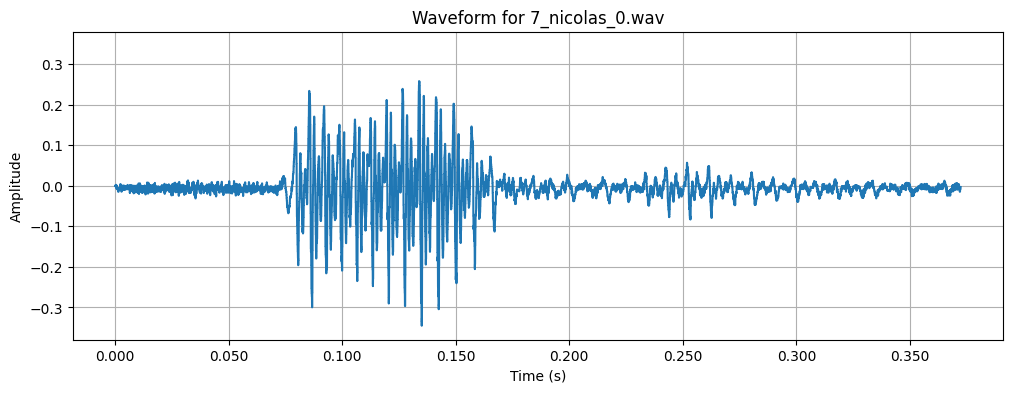

In [11]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f'Waveform for {os.path.basename(example_file)}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


MFCCs shape: (13, 17)


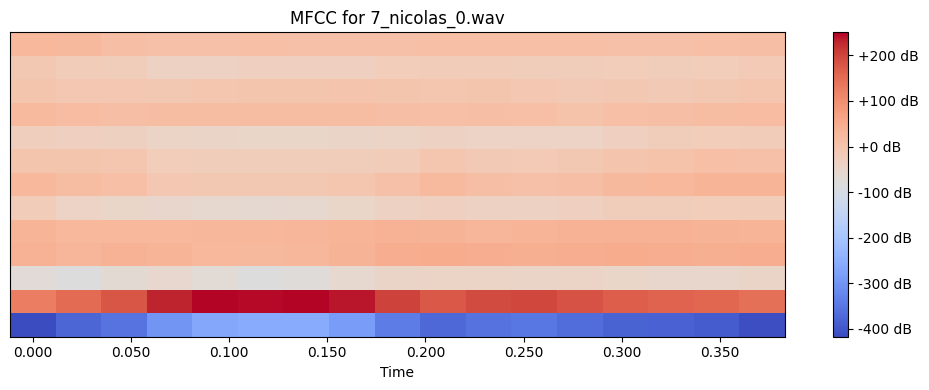

In [12]:
# Extract 13 MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

print(f"MFCCs shape: {mfccs.shape}")

# Visualize the MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(f'MFCC for {os.path.basename(example_file)}')
plt.tight_layout()
plt.show()



--- Processing digit: 0 ---

Analyzing file (1/2): 0_george_0.wav
  - Duration: 0.30 s
  - Avg ZCR: 0.1517
  - Avg RMS: 0.0836
  - Peaks (height>0.18): 49


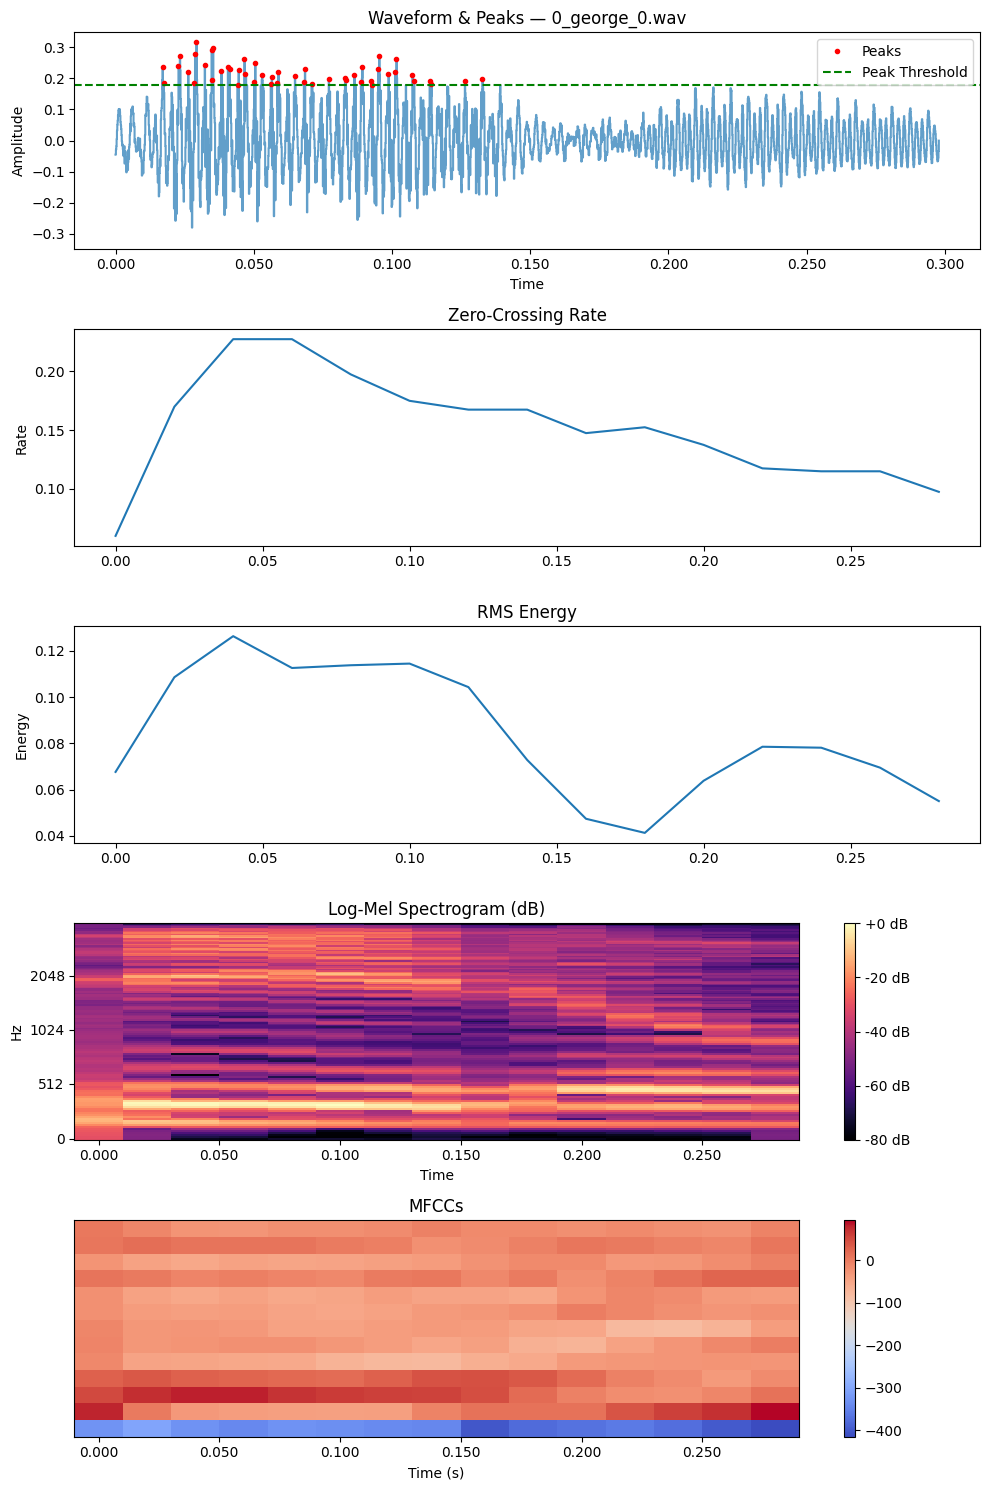


Analyzing file (2/2): 0_george_1.wav
  - Duration: 0.59 s
  - Avg ZCR: 0.1202
  - Avg RMS: 0.0424
  - Peaks (height>0.10): 78


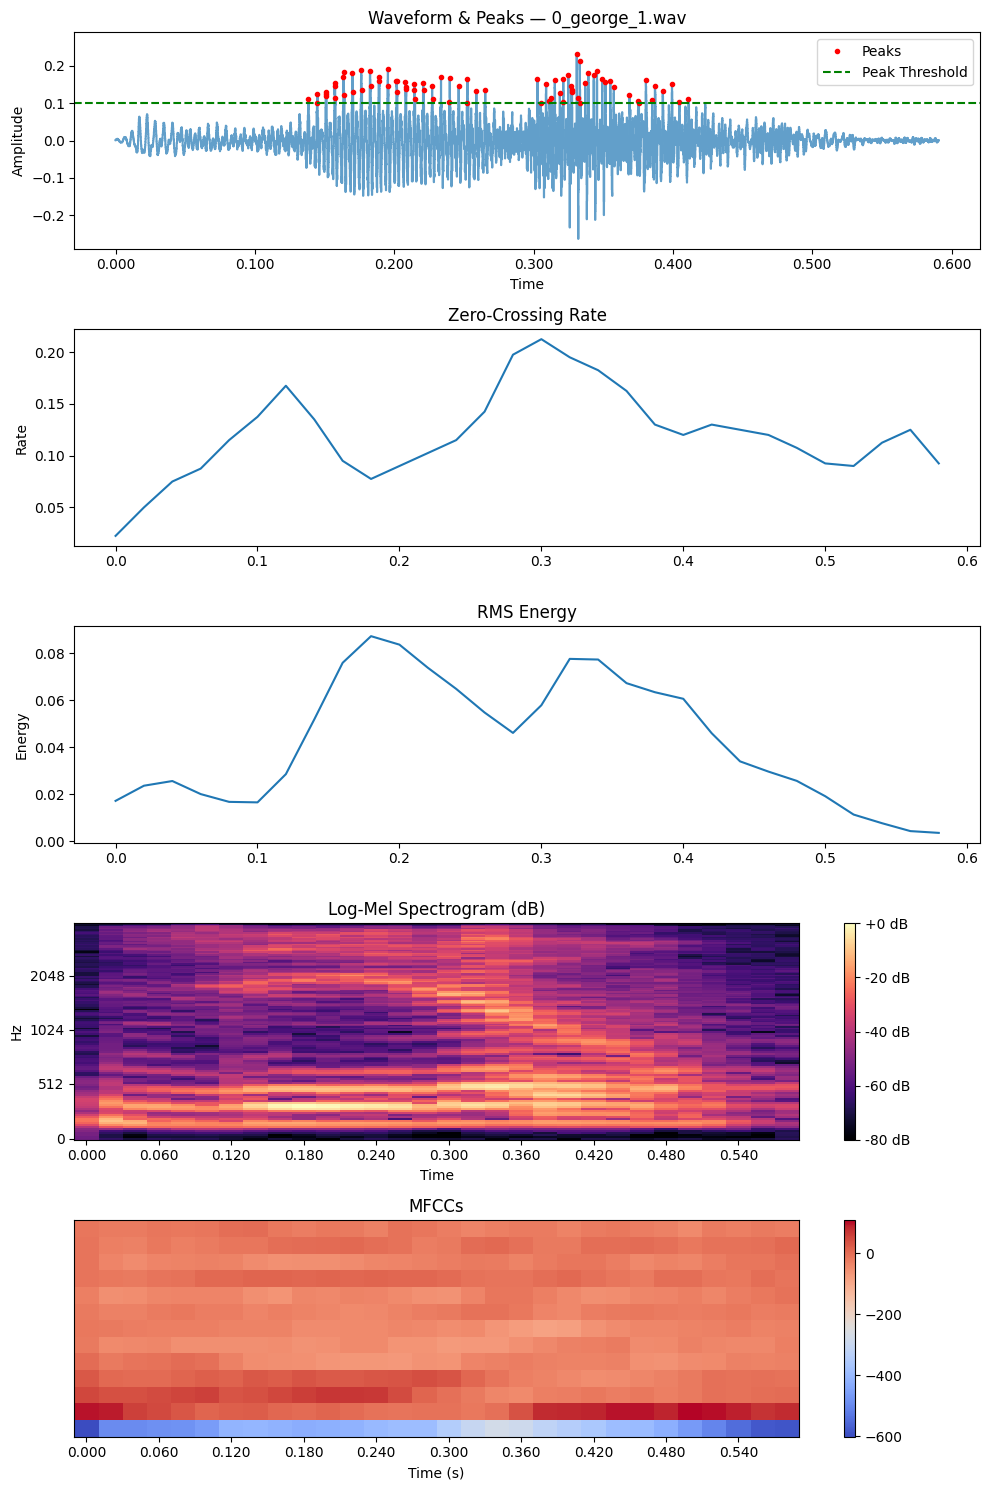


--- Processing digit: 5 ---

Analyzing file (1/2): 5_george_0.wav
  - Duration: 0.56 s
  - Avg ZCR: 0.2037
  - Avg RMS: 0.0561
  - Peaks (height>0.15): 85


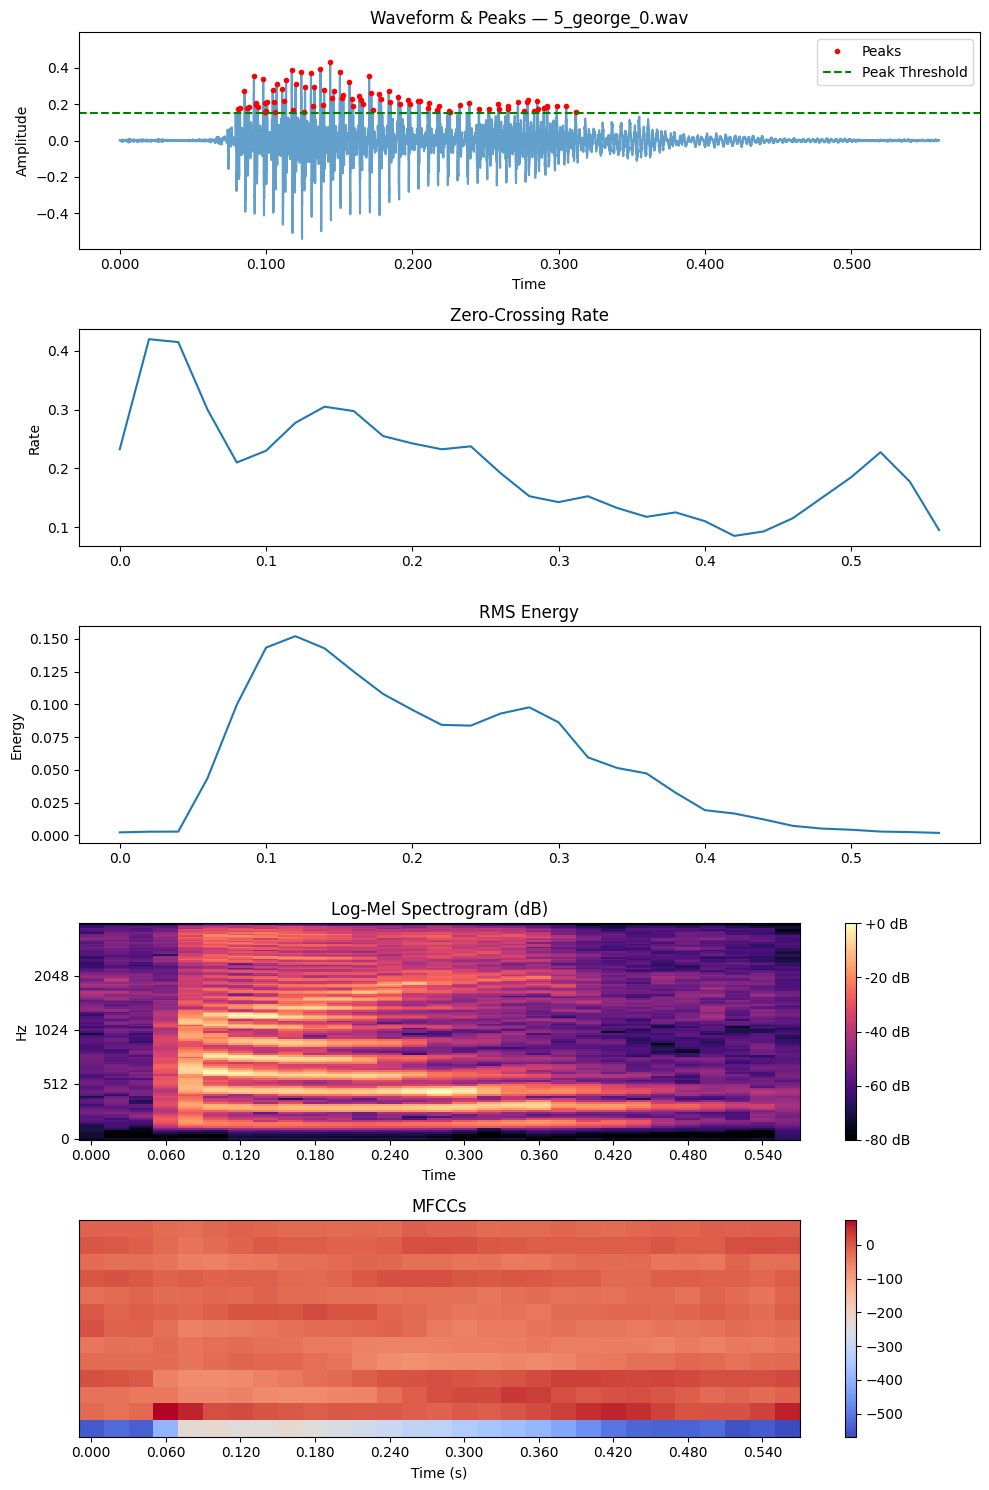


Analyzing file (2/2): 5_george_1.wav
  - Duration: 0.58 s
  - Avg ZCR: 0.2124
  - Avg RMS: 0.0652
  - Peaks (height>0.17): 82


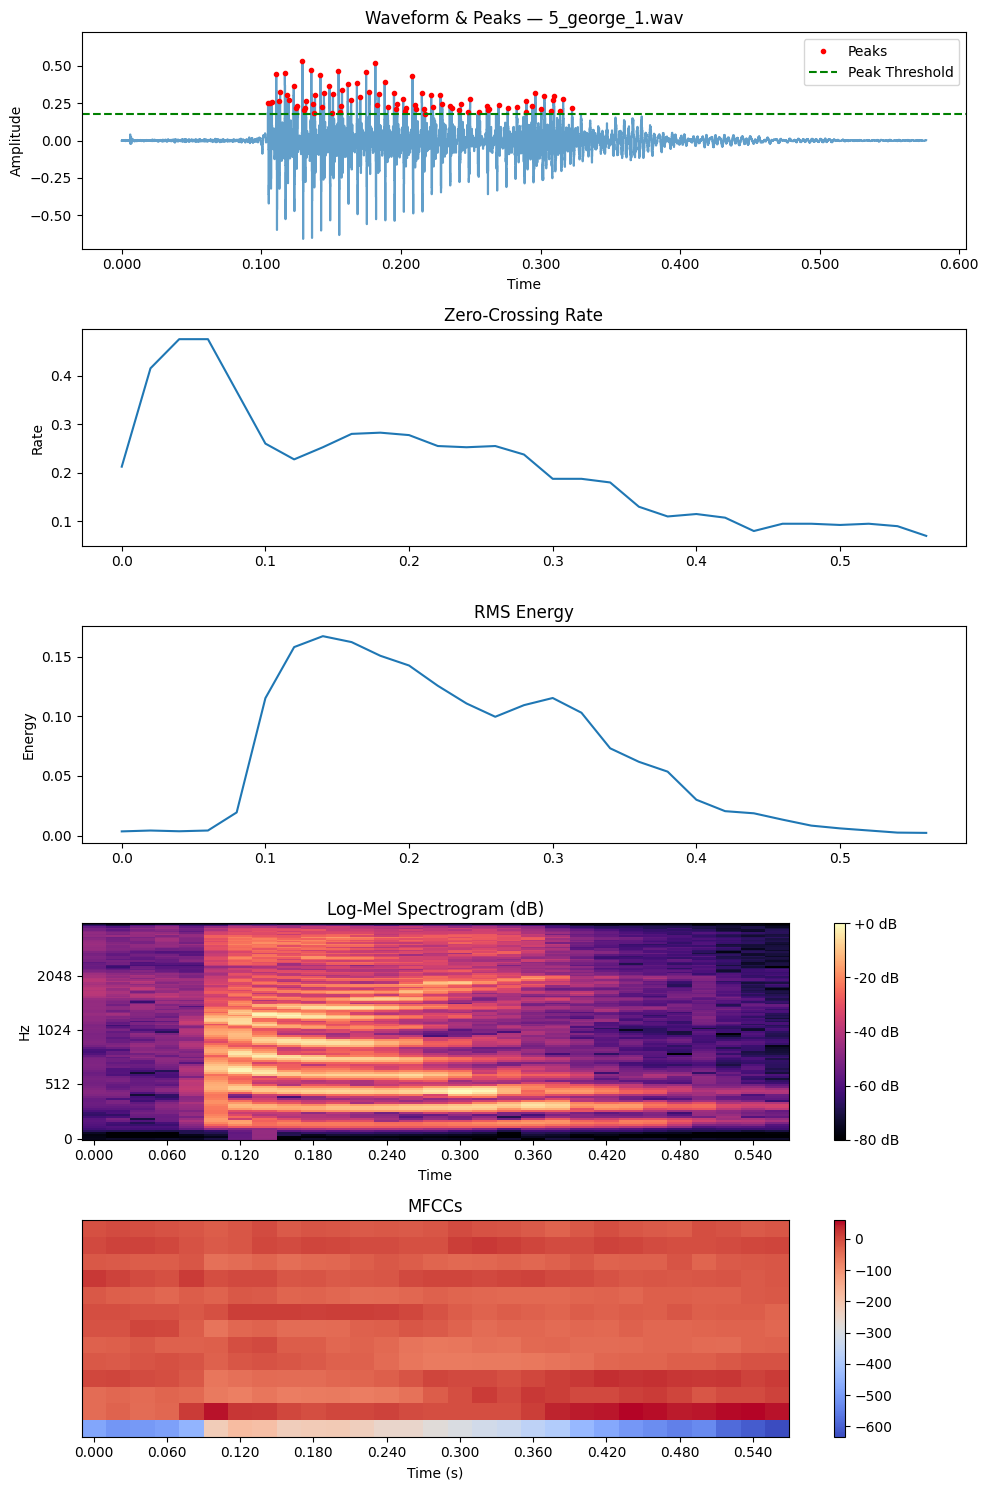


--- Processing digit: 8 ---

Analyzing file (1/2): 8_george_0.wav
  - Duration: 0.53 s
  - Avg ZCR: 0.1735
  - Avg RMS: 0.0646
  - Peaks (height>0.19): 74


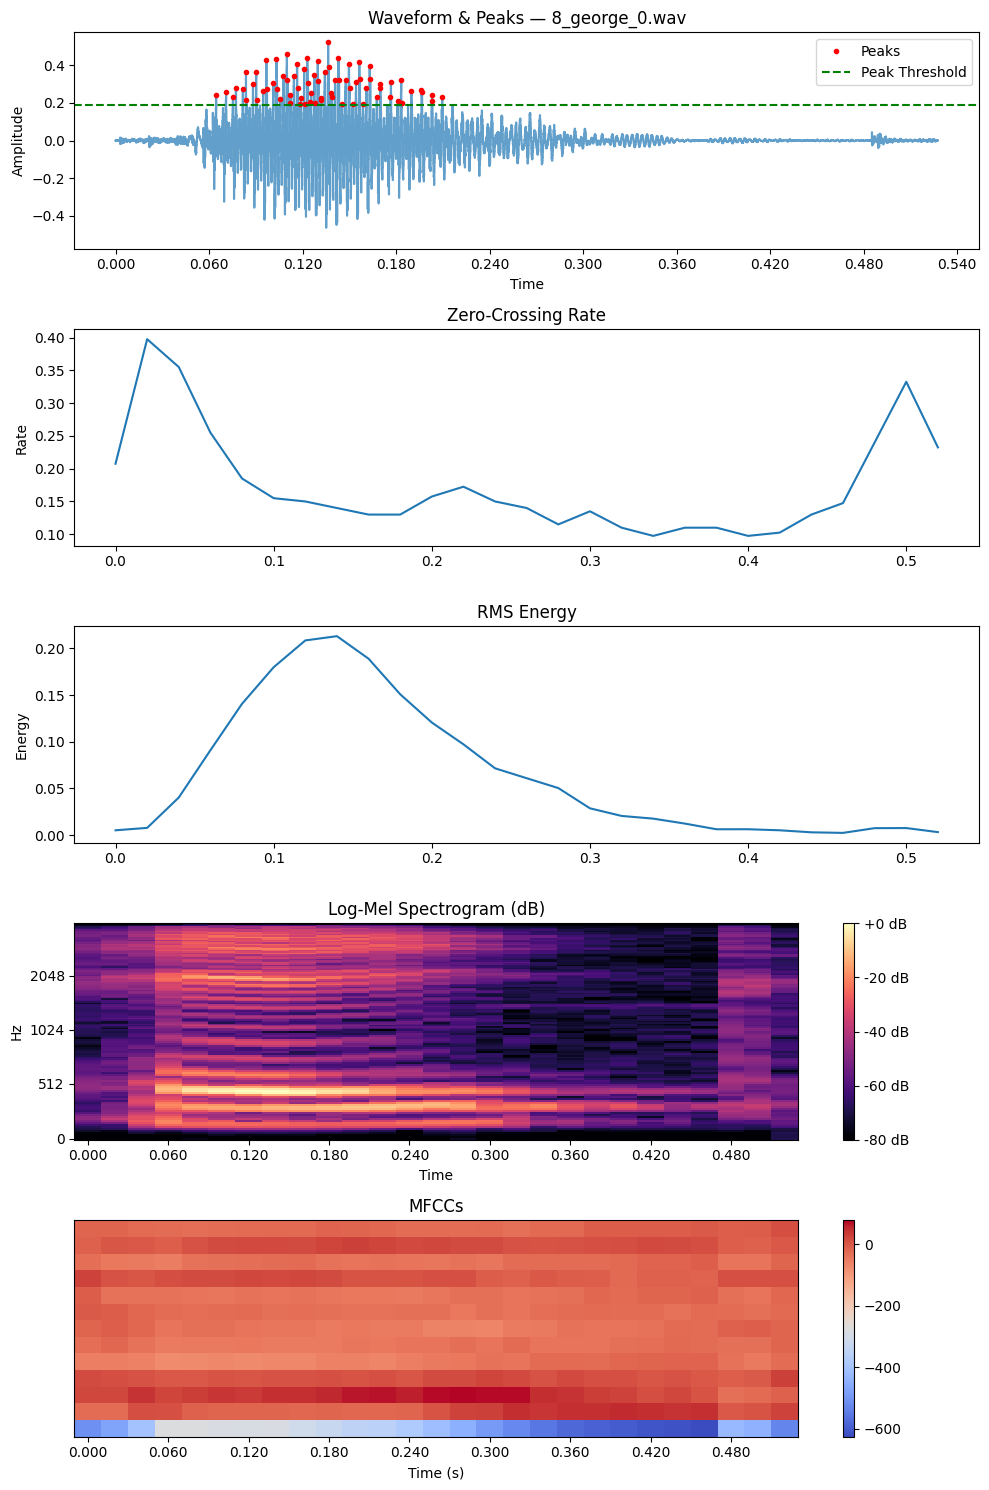


Analyzing file (2/2): 8_george_1.wav
  - Duration: 0.51 s
  - Avg ZCR: 0.1644
  - Avg RMS: 0.0515
  - Peaks (height>0.14): 71


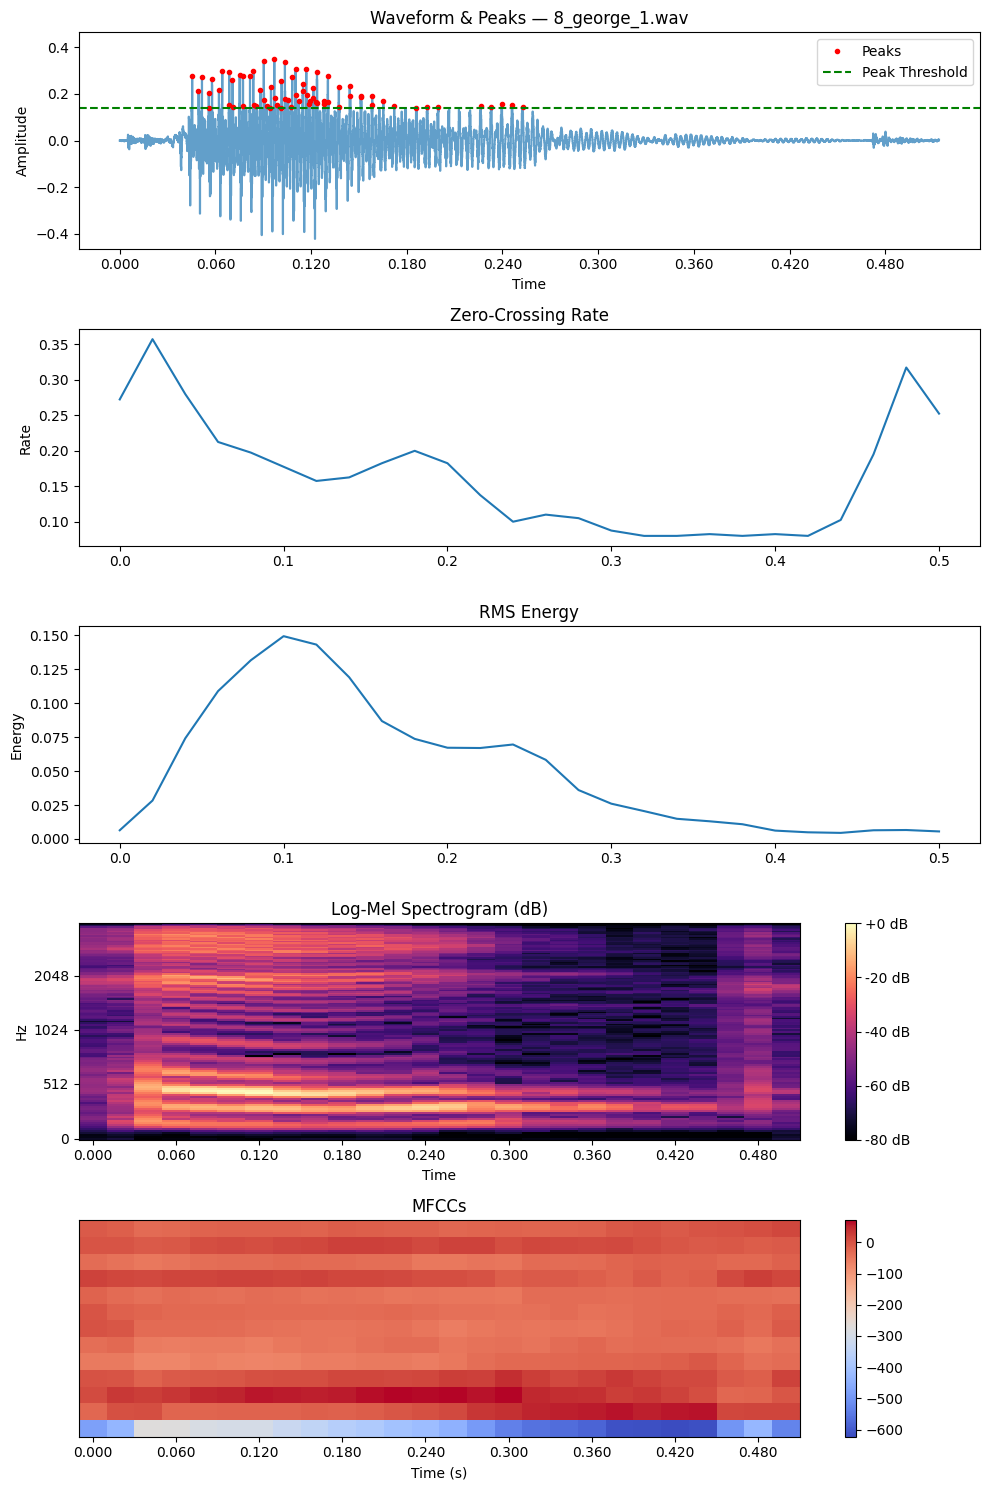

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.signal import find_peaks

def analyze_audio_features(data_dir, digits_to_process, files_per_digit=2):
    """
    Loads audio files for specified digits and analyzes a wide range of
    audio features, printing stats and visualizing the results.

    Args:
        data_dir (str): The path to the directory containing audio files.
        digits_to_process (list[str or int]): Digits to analyze.
        files_per_digit (int): Number of files per digit.
    """
    if not os.path.isdir(data_dir):
        print(f"Error: Data directory not found at '{data_dir}'")
        print("Please clone FSDD and set DATA_DIR to the recordings folder.")
        return

    # Analysis params (consistent across features)
    SR = 8000
    N_FFT = 400       # ~50 ms at 8 kHz
    HOP = 160         # 20 ms hop
    N_MELS = 128
    N_MFCC = 13

    all_files = [f for f in os.listdir(data_dir) if f.endswith(".wav")]

    # Normalize digits to strings for matching filenames like "3_jackson_32.wav"
    digits_to_process = [str(d) for d in digits_to_process]

    for digit in digits_to_process:
        print(f"\n--- Processing digit: {digit} ---")

        digit_files = sorted([f for f in all_files if f.startswith(f"{digit}_")])
        if not digit_files:
            print(f"No .wav files found for digit '{digit}' in '{data_dir}'.")
            continue

        for i, filename in enumerate(digit_files[:files_per_digit]):
            file_path = os.path.join(data_dir, filename)
            print(f"\nAnalyzing file ({i+1}/{files_per_digit}): {filename}")

            try:
                # 1) Load audio at 8 kHz to match dataset and keep everything consistent
                y, sr = librosa.load(file_path, sr=SR)

                # --- 2) Extract Features ---
                # Duration
                duration = librosa.get_duration(y=y, sr=sr)

                # Zero-Crossing Rate (per frame)
                zcr = librosa.feature.zero_crossing_rate(y, frame_length=N_FFT, hop_length=HOP)[0]
                t_zcr = librosa.times_like(zcr, sr=sr, hop_length=HOP)

                # Root-Mean-Square energy (per frame)
                rms = librosa.feature.rms(y=y, frame_length=N_FFT, hop_length=HOP)[0]
                t_rms = librosa.times_like(rms, sr=sr, hop_length=HOP)

                # Peaks in the waveform (use sample indices -> convert to seconds)
                # A dynamic threshold is more robust to variations in recording volume.
                peak_threshold = np.std(y) * 2.0  # e.g., 2 standard deviations
                peaks, _ = find_peaks(y, height=peak_threshold)
                t_peaks = peaks / sr

                # Log-Mel Spectrogram
                S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS, power=2.0)
                log_mel_S = librosa.power_to_db(S, ref=np.max)

                # MFCCs
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC,
                                             n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS)

                # --- 3) Print Analysis ---
                print(f"  - Duration: {duration:.2f} s")
                print(f"  - Avg ZCR: {np.mean(zcr):.4f}")
                print(f"  - Avg RMS: {np.mean(rms):.4f}")
                print(f"  - Peaks (height>{peak_threshold:.2f}): {len(peaks)}")

                # --- 4) Visualize ---
                fig, axs = plt.subplots(5, 1, figsize=(10, 15))

                # Plot 1: Waveform + peaks
                librosa.display.waveshow(y, sr=sr, ax=axs[0], alpha=0.7)
                axs[0].plot(t_peaks, y[peaks], "r.", markersize=6, label="Peaks")
                axs[0].axhline(y=peak_threshold, color='g', linestyle='--', label='Peak Threshold')
                axs[0].set_title(f"Waveform & Peaks — {filename}")
                axs[0].set_ylabel("Amplitude")
                axs[0].legend(loc="upper right")

                # Plot 2: ZCR
                axs[1].plot(t_zcr, zcr)
                axs[1].set_title("Zero-Crossing Rate")
                axs[1].set_ylabel("Rate")

                # Plot 3: RMS
                axs[2].plot(t_rms, rms)
                axs[2].set_title("RMS Energy")
                axs[2].set_ylabel("Energy")

                # Plot 4: Log-Mel Spectrogram (time axis needs sr + hop)
                img1 = librosa.display.specshow(log_mel_S, sr=sr, hop_length=HOP,
                                                x_axis="time", y_axis="mel", ax=axs[3])
                axs[3].set_title("Log-Mel Spectrogram (dB)")
                fig.colorbar(img1, ax=axs[3], format="%+2.0f dB")

                # Plot 5: MFCCs
                img2 = librosa.display.specshow(mfccs, sr=sr, hop_length=HOP,
                                                x_axis="time", ax=axs[4])
                axs[4].set_title("MFCCs")
                axs[4].set_xlabel("Time (s)")
                fig.colorbar(img2, ax=axs[4])

                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"Error processing {filename}: {e}")

if __name__ == '__main__':
    DATA_DIR = "free-spoken-digit-dataset/recordings"
    DIGITS_TO_PROCESS = ['0', '5', '8']
    FILES_PER_DIGIT = 2

    analyze_audio_features(DATA_DIR, DIGITS_TO_PROCESS, FILES_PER_DIGIT)


Comparing '4_george_0.wav' vs '1_george_0.wav'


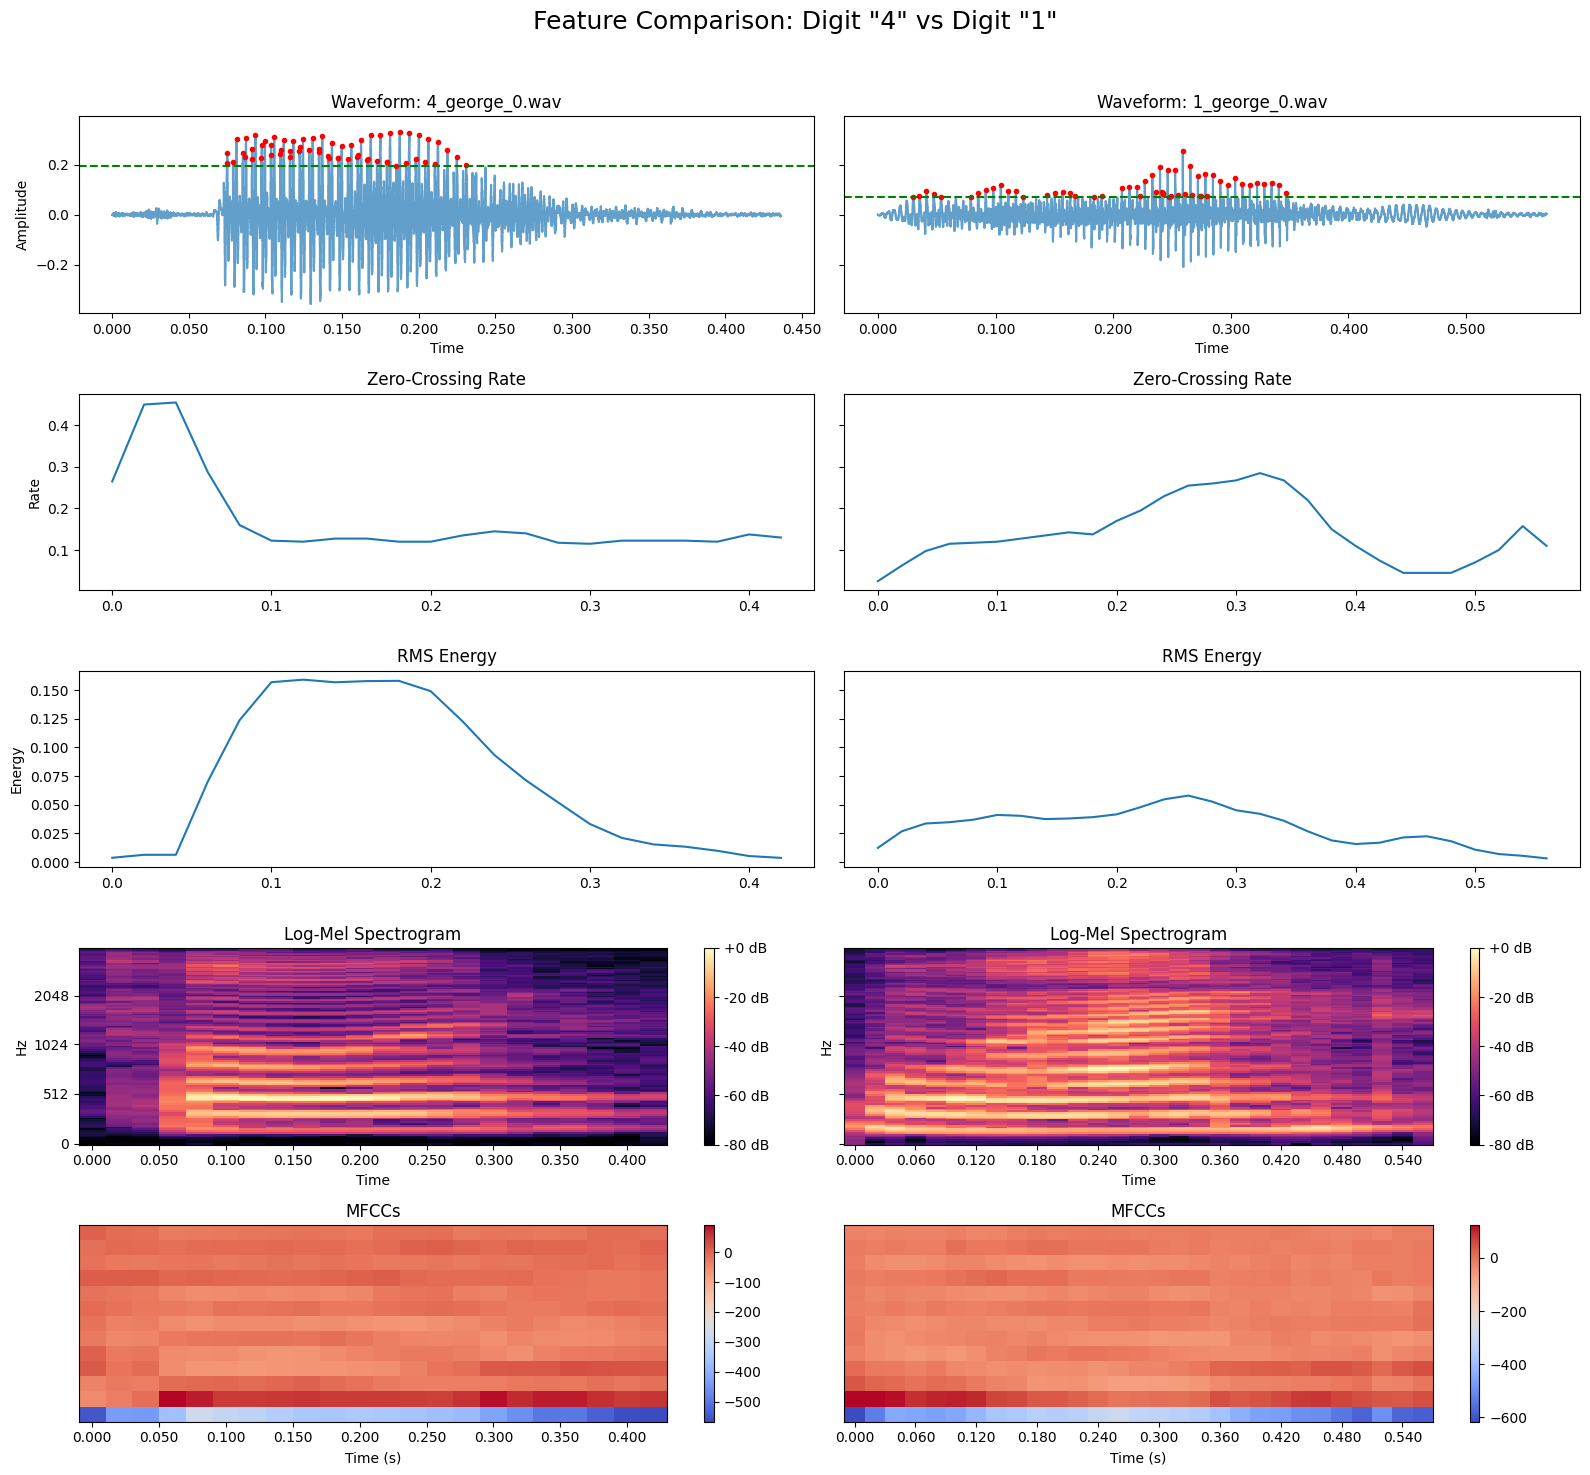

In [23]:
def _extract_all_features(y, sr, n_fft, hop_length, n_mels, n_mfcc):
    """Helper to extract all features for a given audio signal."""
    features = {}
    features['y'] = y
    features['sr'] = sr
    
    # Time-domain features
    peak_threshold = np.std(y) * 2.0  # Dynamic threshold
    peaks, _ = find_peaks(y, height=peak_threshold)
    features['peaks'] = peaks
    features['peak_threshold'] = peak_threshold
    features['t_peaks'] = peaks / sr
    
    # Frame-based features
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length)[0]
    features['t_zcr'] = librosa.times_like(features['zcr'], sr=sr, hop_length=hop_length)
    
    features['rms'] = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)[0]
    features['t_rms'] = librosa.times_like(features['rms'], sr=sr, hop_length=hop_length)
    
    # Spectrograms
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    features['log_mel_S'] = librosa.power_to_db(S, ref=np.max)
    
    features['mfccs'] = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    return features

def compare_audio_features(data_dir, digit1, digit2):
    """
    Loads one audio file for each of two specified digits and creates a
    side-by-side comparison plot of their audio features.

    Args:
        data_dir (str): Path to the directory containing audio files.
        digit1 (str): The first digit to compare (e.g., '3').
        digit2 (str): The second digit to compare (e.g., '8').
    """
    if not os.path.isdir(data_dir):
        print(f"Error: Data directory not found at '{data_dir}'")
        return

    # Analysis params from your script
    SR = 8000
    N_FFT = 400
    HOP = 160
    N_MELS = 128
    N_MFCC = 13

    # --- Find and load one file for each digit ---
    all_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".wav")])
    
    file1_name = next((f for f in all_files if f.startswith(f"{digit1}_")), None)
    file2_name = next((f for f in all_files if f.startswith(f"{digit2}_")), None)

    if not file1_name or not file2_name:
        if not file1_name: print(f"Could not find a file for digit '{digit1}'")
        if not file2_name: print(f"Could not find a file for digit '{digit2}'")
        return
        
    file1_path = os.path.join(data_dir, file1_name)
    file2_path = os.path.join(data_dir, file2_name)
    
    print(f"Comparing '{file1_name}' vs '{file2_name}'")

    # --- Load and extract features for both files ---
    y1, sr1 = librosa.load(file1_path, sr=SR)
    features1 = _extract_all_features(y1, sr1, N_FFT, HOP, N_MELS, N_MFCC)
    
    y2, sr2 = librosa.load(file2_path, sr=SR)
    features2 = _extract_all_features(y2, sr2, N_FFT, HOP, N_MELS, N_MFCC)

    # --- Create the comparison plot ---
    fig, axs = plt.subplots(5, 2, figsize=(16, 15), sharey='row')
    fig.suptitle(f'Feature Comparison: Digit "{digit1}" vs Digit "{digit2}"', fontsize=18)

    # --- Column 1: Digit 1 ---
    ax_col1 = axs[:, 0]
    librosa.display.waveshow(features1['y'], sr=features1['sr'], ax=ax_col1[0], alpha=0.7)
    ax_col1[0].plot(features1['t_peaks'], features1['y'][features1['peaks']], "r.", markersize=6)
    ax_col1[0].axhline(y=features1['peak_threshold'], color='g', linestyle='--')
    ax_col1[0].set_title(f"Waveform: {file1_name}")
    ax_col1[0].set_ylabel("Amplitude")

    ax_col1[1].plot(features1['t_zcr'], features1['zcr'])
    ax_col1[1].set_title("Zero-Crossing Rate")
    ax_col1[1].set_ylabel("Rate")

    ax_col1[2].plot(features1['t_rms'], features1['rms'])
    ax_col1[2].set_title("RMS Energy")
    ax_col1[2].set_ylabel("Energy")

    img1 = librosa.display.specshow(features1['log_mel_S'], sr=SR, hop_length=HOP, x_axis="time", y_axis="mel", ax=ax_col1[3])
    ax_col1[3].set_title("Log-Mel Spectrogram")
    fig.colorbar(img1, ax=ax_col1[3], format="%+2.0f dB")

    img2 = librosa.display.specshow(features1['mfccs'], sr=SR, hop_length=HOP, x_axis="time", ax=ax_col1[4])
    ax_col1[4].set_title("MFCCs")
    ax_col1[4].set_xlabel("Time (s)")
    fig.colorbar(img2, ax=ax_col1[4])

    # --- Column 2: Digit 2 ---
    ax_col2 = axs[:, 1]
    librosa.display.waveshow(features2['y'], sr=features2['sr'], ax=ax_col2[0], alpha=0.7)
    ax_col2[0].plot(features2['t_peaks'], features2['y'][features2['peaks']], "r.", markersize=6)
    ax_col2[0].axhline(y=features2['peak_threshold'], color='g', linestyle='--')
    ax_col2[0].set_title(f"Waveform: {file2_name}")

    ax_col2[1].plot(features2['t_zcr'], features2['zcr'])
    ax_col2[1].set_title("Zero-Crossing Rate")

    ax_col2[2].plot(features2['t_rms'], features2['rms'])
    ax_col2[2].set_title("RMS Energy")

    img3 = librosa.display.specshow(features2['log_mel_S'], sr=SR, hop_length=HOP, x_axis="time", y_axis="mel", ax=ax_col2[3])
    ax_col2[3].set_title("Log-Mel Spectrogram")
    fig.colorbar(img3, ax=ax_col2[3], format="%+2.0f dB")

    img4 = librosa.display.specshow(features2['mfccs'], sr=SR, hop_length=HOP, x_axis="time", ax=ax_col2[4])
    ax_col2[4].set_title("MFCCs")
    ax_col2[4].set_xlabel("Time (s)")
    fig.colorbar(img4, ax=ax_col2[4])

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
    plt.show()

if __name__ == '__main__':
    DATA_DIR = "free-spoken-digit-dataset/recordings"
    # Compare the features of the first available '4' and '7'
    compare_audio_features(DATA_DIR, digit1='4', digit2='1')



--- Performing Inter-Class Comparison (e.g., '3' vs '8') ---


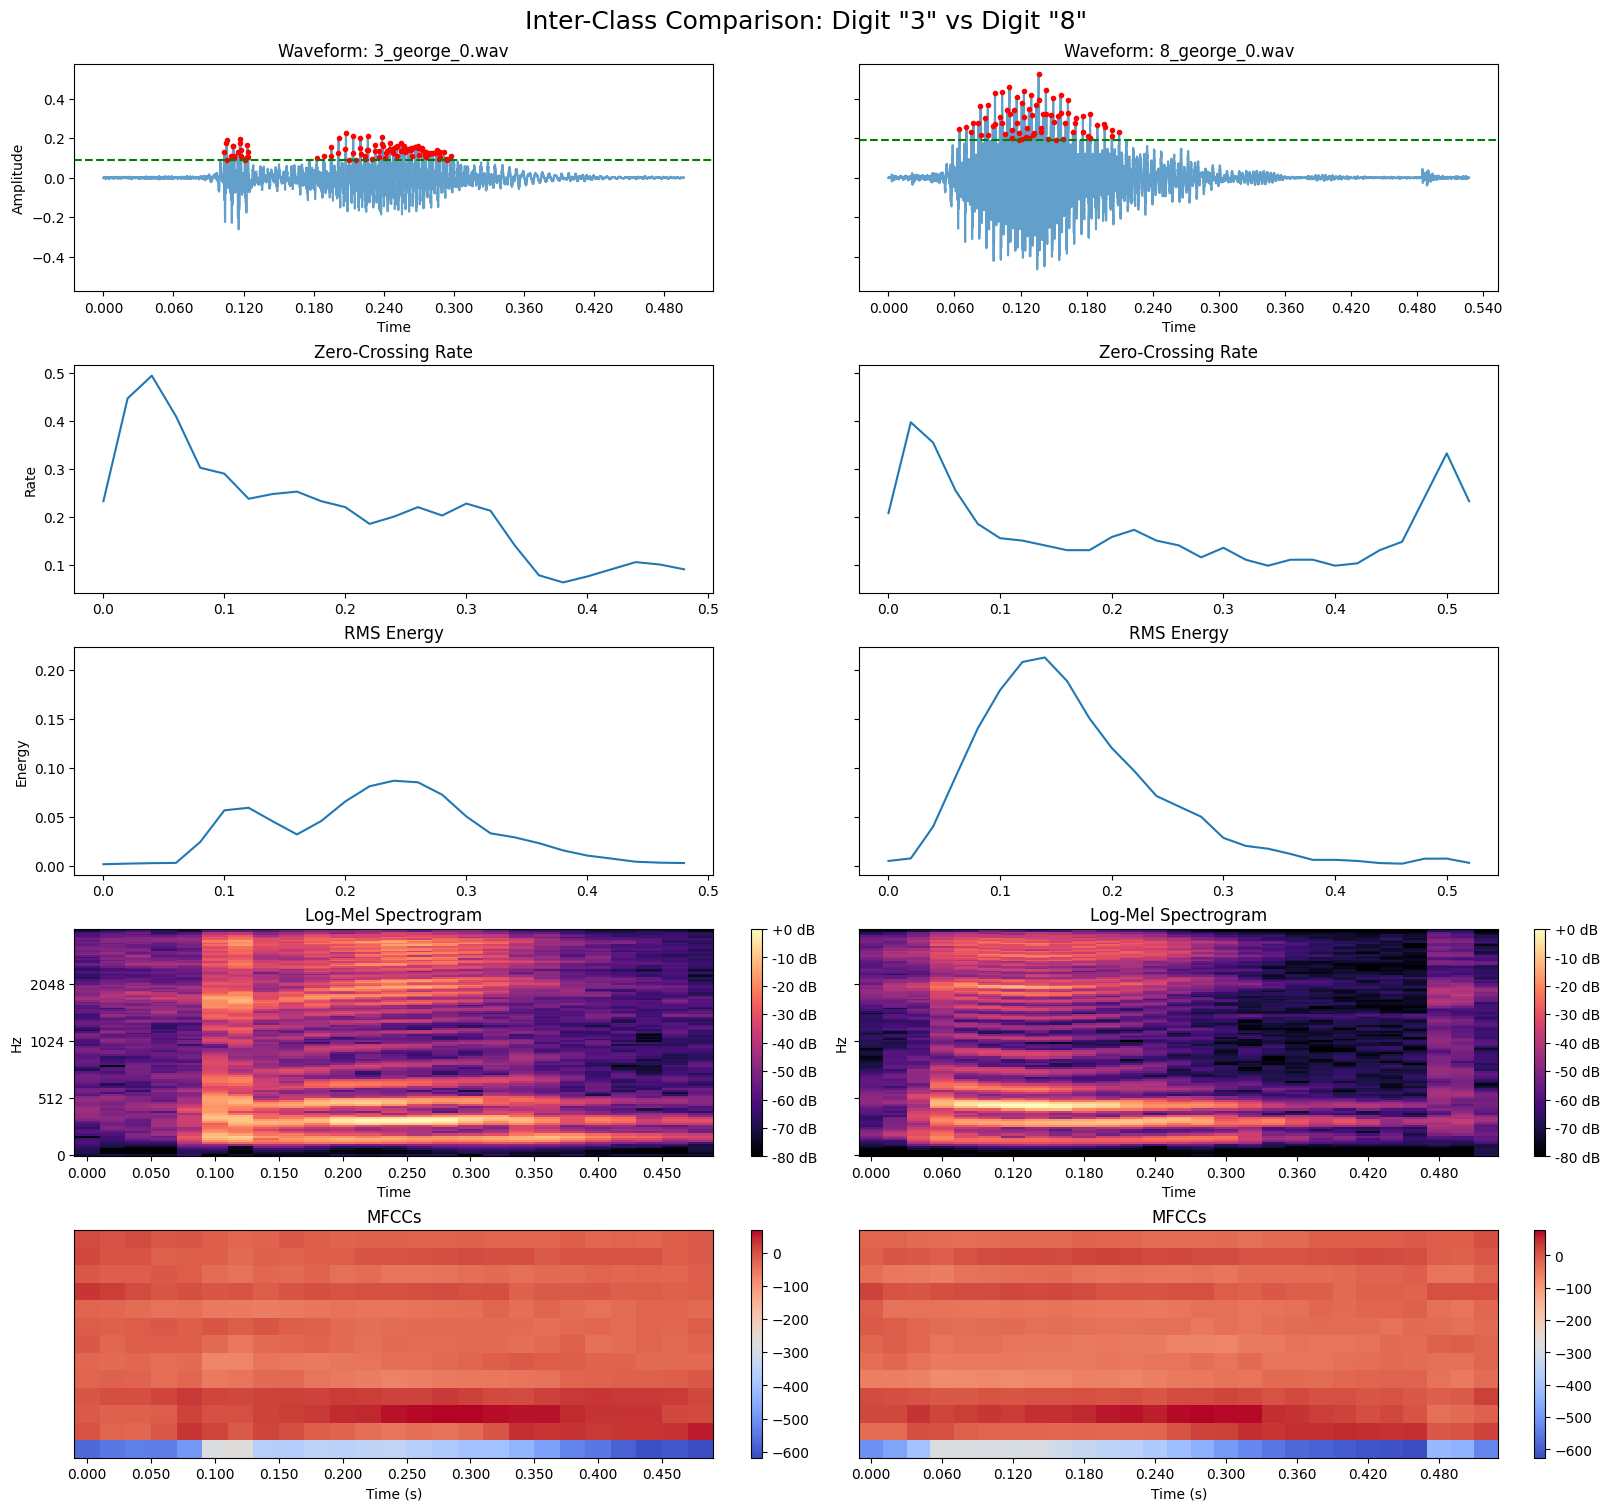


--- Performing Intra-Class Comparison (e.g., two '7's) ---


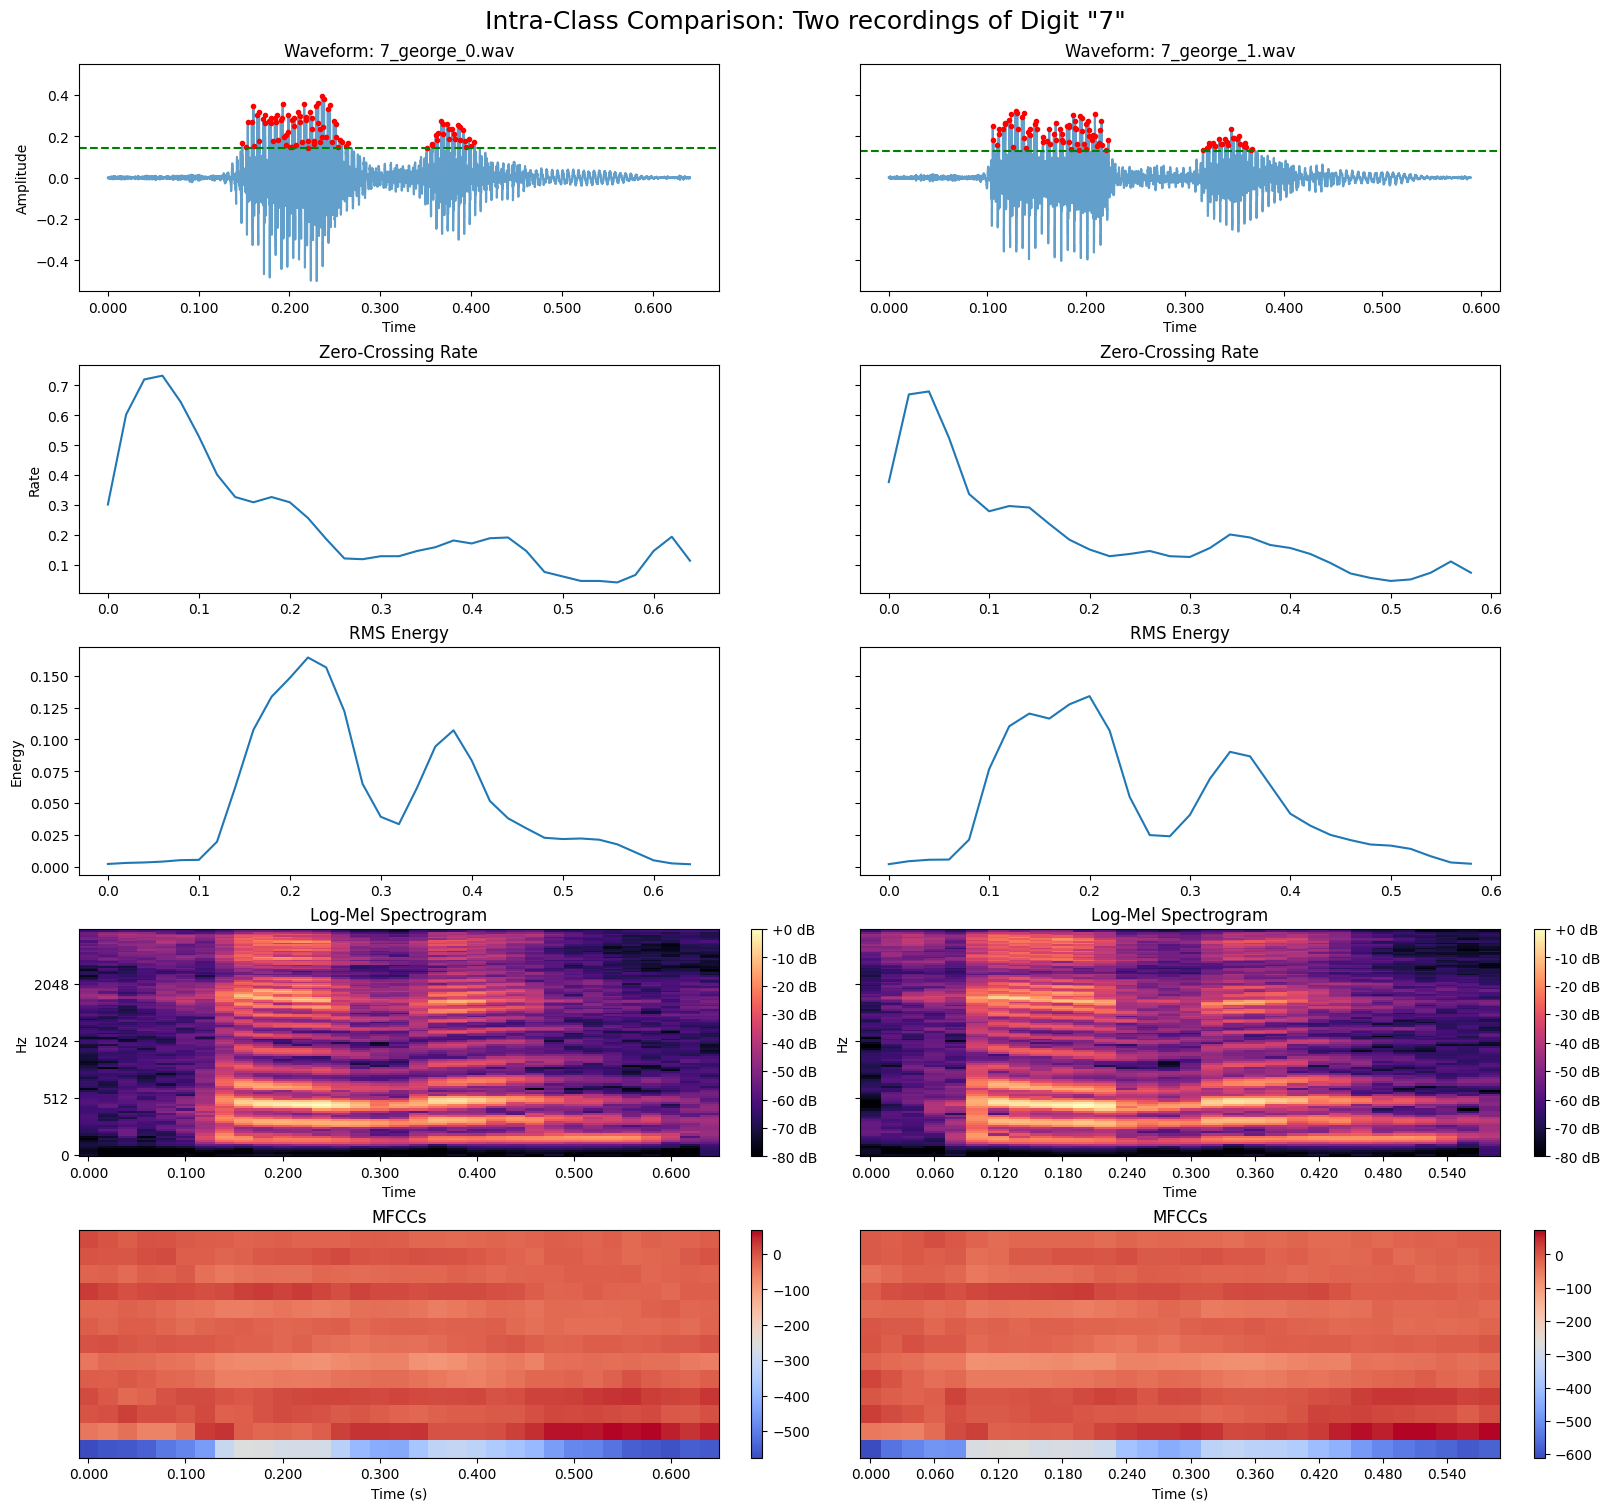

In [24]:
def _extract_all_features(y, sr, n_fft, hop_length, n_mels, n_mfcc):
    """Helper to extract a dictionary of features for a given audio signal."""
    features = {}
    features['y'] = y
    features['sr'] = sr

    # Time-domain features
    peak_threshold = np.std(y) * 2.0  # Dynamic threshold
    peaks, _ = find_peaks(y, height=peak_threshold)
    features['peaks'] = peaks
    features['peak_threshold'] = peak_threshold
    features['t_peaks'] = librosa.samples_to_time(peaks, sr=sr)

    # Frame-based features
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length)[0]
    features['t_zcr'] = librosa.times_like(features['zcr'], sr=sr, hop_length=hop_length)

    features['rms'] = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)[0]
    features['t_rms'] = librosa.times_like(features['rms'], sr=sr, hop_length=hop_length)

    # Spectrograms
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    features['log_mel_S'] = librosa.power_to_db(S, ref=np.max)

    features['mfccs'] = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

    return features

def plot_feature_comparison(features1, file1_name, features2, file2_name, suptitle):
    """
    Creates a side-by-side comparison plot of audio features for two audio files.

    Args:
        features1 (dict): Feature dictionary for the first audio file.
        file1_name (str): Filename of the first audio file.
        features2 (dict): Feature dictionary for the second audio file.
        file2_name (str): Filename of the second audio file.
        suptitle (str): The main title for the entire figure.
    """
    fig, axs = plt.subplots(5, 2, figsize=(16, 15), sharey='row', constrained_layout=True)
    fig.suptitle(suptitle, fontsize=18)

    sr = features1['sr']
    hop_length = int(sr * 0.020) # Assuming 20ms hop, for display only

    # --- Column 1: File 1 ---
    ax_col1 = axs[:, 0]
    librosa.display.waveshow(features1['y'], sr=sr, ax=ax_col1[0], alpha=0.7)
    ax_col1[0].plot(features1['t_peaks'], features1['y'][features1['peaks']], "r.", markersize=6)
    ax_col1[0].axhline(y=features1['peak_threshold'], color='g', linestyle='--')
    ax_col1[0].set_title(f"Waveform: {file1_name}")
    ax_col1[0].set_ylabel("Amplitude")

    ax_col1[1].plot(features1['t_zcr'], features1['zcr'])
    ax_col1[1].set_title("Zero-Crossing Rate")
    ax_col1[1].set_ylabel("Rate")

    ax_col1[2].plot(features1['t_rms'], features1['rms'])
    ax_col1[2].set_title("RMS Energy")
    ax_col1[2].set_ylabel("Energy")

    img1 = librosa.display.specshow(features1['log_mel_S'], sr=sr, hop_length=hop_length, x_axis="time", y_axis="mel", ax=ax_col1[3])
    ax_col1[3].set_title("Log-Mel Spectrogram")
    fig.colorbar(img1, ax=ax_col1[3], format="%+2.0f dB")

    img2 = librosa.display.specshow(features1['mfccs'], sr=sr, hop_length=hop_length, x_axis="time", ax=ax_col1[4])
    ax_col1[4].set_title("MFCCs")
    ax_col1[4].set_xlabel("Time (s)")
    fig.colorbar(img2, ax=ax_col1[4])

    # --- Column 2: File 2 ---
    ax_col2 = axs[:, 1]
    librosa.display.waveshow(features2['y'], sr=sr, ax=ax_col2[0], alpha=0.7)
    ax_col2[0].plot(features2['t_peaks'], features2['y'][features2['peaks']], "r.", markersize=6)
    ax_col2[0].axhline(y=features2['peak_threshold'], color='g', linestyle='--')
    ax_col2[0].set_title(f"Waveform: {file2_name}")

    ax_col2[1].plot(features2['t_zcr'], features2['zcr'])
    ax_col2[1].set_title("Zero-Crossing Rate")

    ax_col2[2].plot(features2['t_rms'], features2['rms'])
    ax_col2[2].set_title("RMS Energy")

    img3 = librosa.display.specshow(features2['log_mel_S'], sr=sr, hop_length=hop_length, x_axis="time", y_axis="mel", ax=ax_col2[3])
    ax_col2[3].set_title("Log-Mel Spectrogram")
    fig.colorbar(img3, ax=ax_col2[3], format="%+2.0f dB")

    img4 = librosa.display.specshow(features2['mfccs'], sr=sr, hop_length=hop_length, x_axis="time", ax=ax_col2[4])
    ax_col2[4].set_title("MFCCs")
    ax_col2[4].set_xlabel("Time (s)")
    fig.colorbar(img4, ax=ax_col2[4])

    plt.show()

if __name__ == '__main__':
    # --- Configuration ---
    DATA_DIR = "free-spoken-digit-dataset/recordings"
    SR = 8000
    N_FFT = 400
    HOP = 160
    N_MELS = 128
    N_MFCC = 13

    if not os.path.isdir(DATA_DIR):
        print(f"Error: Data directory not found at '{DATA_DIR}'")
        print("Please download the FSDD dataset and place it in the correct directory.")
    else:
        all_files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith(".wav")])

        # --- 1. Inter-Class Comparison (different digits) ---
        print("--- Performing Inter-Class Comparison (e.g., '3' vs '8') ---")
        digit1, digit2 = '3', '8'
        file1_name = next((f for f in all_files if f.startswith(f"{digit1}_")), None)
        file2_name = next((f for f in all_files if f.startswith(f"{digit2}_")), None)

        if file1_name and file2_name:
            y1, _ = librosa.load(os.path.join(DATA_DIR, file1_name), sr=SR)
            features1 = _extract_all_features(y1, SR, N_FFT, HOP, N_MELS, N_MFCC)

            y2, _ = librosa.load(os.path.join(DATA_DIR, file2_name), sr=SR)
            features2 = _extract_all_features(y2, SR, N_FFT, HOP, N_MELS, N_MFCC)

            plot_feature_comparison(
                features1, file1_name,
                features2, file2_name,
                suptitle=f'Inter-Class Comparison: Digit "{digit1}" vs Digit "{digit2}"'
            )
        else:
            print(f"Could not find files for both digits '{digit1}' and '{digit2}' to compare.")


        # --- 2. Intra-Class Comparison (same digit, different recordings) ---
        print("\n--- Performing Intra-Class Comparison (e.g., two '7's) ---")
        digit_to_compare = '7'
        files_for_digit = [f for f in all_files if f.startswith(f"{digit_to_compare}_")]

        if len(files_for_digit) >= 2:
            file1_name = files_for_digit[0]
            file2_name = files_for_digit[1] # Get the first two files for this digit

            y1, _ = librosa.load(os.path.join(DATA_DIR, file1_name), sr=SR)
            features1 = _extract_all_features(y1, SR, N_FFT, HOP, N_MELS, N_MFCC)

            y2, _ = librosa.load(os.path.join(DATA_DIR, file2_name), sr=SR)
            features2 = _extract_all_features(y2, SR, N_FFT, HOP, N_MELS, N_MFCC)

            plot_feature_comparison(
                features1, file1_name,
                features2, file2_name,
                suptitle=f'Intra-Class Comparison: Two recordings of Digit "{digit_to_compare}"'
            )
        else:
            print(f"Could not find at least two files for digit '{digit_to_compare}' to compare.")



In [25]:
import os, soundfile as sf
from collections import Counter

DATA_DIR = "free-spoken-digit-dataset/recordings"
rates = []
for fn in os.listdir(DATA_DIR):
    if fn.endswith(".wav"):
        try:
            info = sf.info(os.path.join(DATA_DIR, fn))
            rates.append(info.samplerate)
        except:
            pass

print("Unique sample rates:", sorted(set(rates)))
print("Counts:", Counter(rates))


Unique sample rates: [8000]
Counts: Counter({8000: 3000})
